CUDA Available: True
GPU Device: Tesla T4


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


[VGG16] Epoch 1/5 | Train Acc: 72.50% | Val Acc: 78.23%
[VGG16] Epoch 2/5 | Train Acc: 74.80% | Val Acc: 78.09%
[VGG16] Epoch 3/5 | Train Acc: 75.39% | Val Acc: 79.95%
[VGG16] Epoch 4/5 | Train Acc: 75.84% | Val Acc: 79.37%
[VGG16] Epoch 5/5 | Train Acc: 75.74% | Val Acc: 79.94%


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


[RESNET18] Epoch 1/5 | Train Acc: 73.23% | Val Acc: 77.60%
[RESNET18] Epoch 2/5 | Train Acc: 78.77% | Val Acc: 79.89%
[RESNET18] Epoch 3/5 | Train Acc: 79.55% | Val Acc: 79.88%
[RESNET18] Epoch 4/5 | Train Acc: 80.08% | Val Acc: 80.21%
[RESNET18] Epoch 5/5 | Train Acc: 80.16% | Val Acc: 79.73%


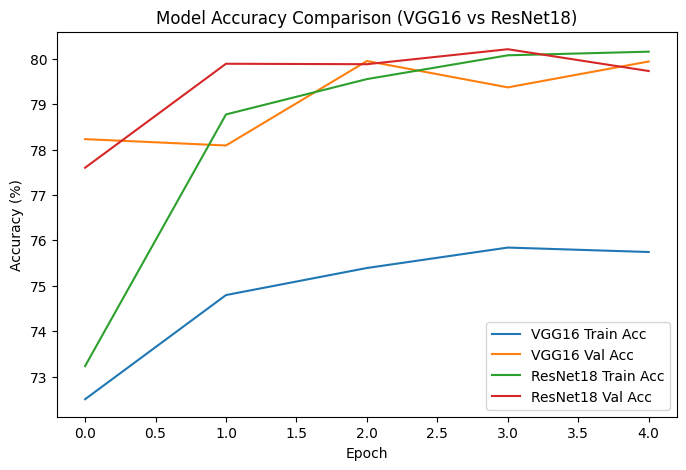

In [ ]:
#LAB14

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import models
import gc

# Step 3: Check GPU and CUDA availability
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4: Data preprocessing
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Step 5: Load pre-trained models
def get_model(model_name):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    if model_name == 'vgg16':
        model.classifier[6] = nn.Linear(4096, 10)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)

    return model.to(device)

# Step 6: Train function
def train_model(model, model_name, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc.append(100 * correct / total)

        print(f"[{model_name.upper()}] Epoch {epoch+1}/{epochs} | Train Acc: {train_acc[-1]:.2f}% | Val Acc: {val_acc[-1]:.2f}%")

    return train_acc, val_acc

# Step 7: Train both models
vgg_model = get_model('vgg16')
vgg_train, vgg_val = train_model(vgg_model, 'vgg16', epochs=5)

del vgg_model
gc.collect()
torch.cuda.empty_cache()

resnet_model = get_model('resnet18')
res_train, res_val = train_model(resnet_model, 'resnet18', epochs=5)

# Step 8: Plot accuracy graphs
plt.figure(figsize=(8,5))
plt.plot(vgg_train, label='VGG16 Train Acc')
plt.plot(vgg_val, label='VGG16 Val Acc')
plt.plot(res_train, label='ResNet18 Train Acc')
plt.plot(res_val, label='ResNet18 Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison (VGG16 vs ResNet18)')
plt.legend()
plt.show()


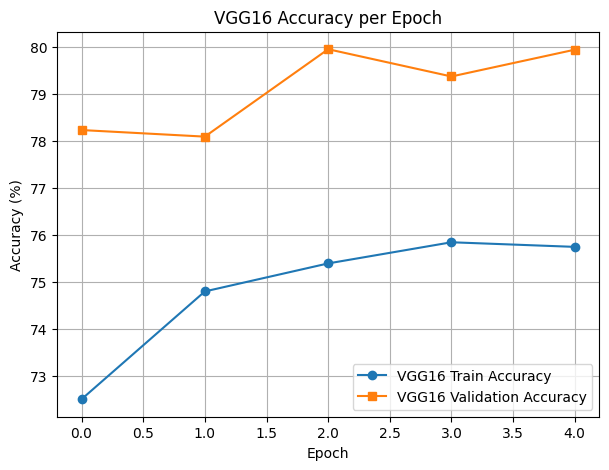

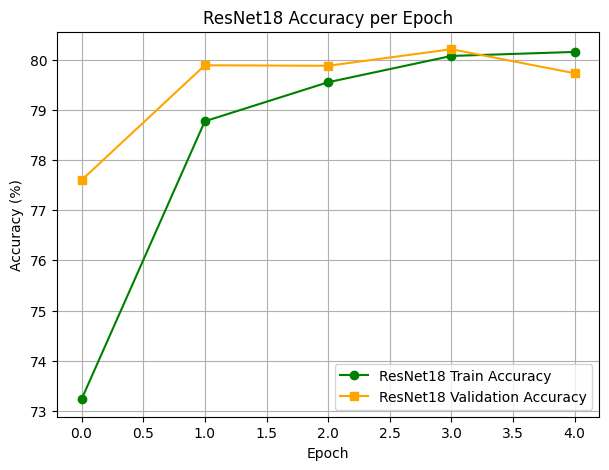

In [ ]:
# Separate accuracy graphs for clarity

# --- Plot VGG16 ---
plt.figure(figsize=(7,5))
plt.plot(vgg_train, label='VGG16 Train Accuracy', marker='o')
plt.plot(vgg_val, label='VGG16 Validation Accuracy', marker='s')
plt.title('VGG16 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot ResNet18 ---
plt.figure(figsize=(7,5))
plt.plot(res_train, label='ResNet18 Train Accuracy', marker='o', color='green')
plt.plot(res_val, label='ResNet18 Validation Accuracy', marker='s', color='orange')
plt.title('ResNet18 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
